

##Implement a neural network for m-samples, n-features as we discussed in class (both FP and BP) and for N layers in the hidden layer. Split the data (you can use the log. reg. data or any other one) and train your network with 70% of the data. Use 15% for validation  and test your network with the remaining 15% data. Report the evaluation metrics for varying number of layers in the network. Plot the training loss curves.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def Sigmoid(z, diff=False):
    value = 1 / (1 + np.exp(-z))
    if diff:
        value *= (1 - value)
    return value

def Softmax(z, diff=False):
    value = np.exp(z)
    value /= np.sum(value, axis=1, keepdims=True)
    return value

def Relu(z, diff=False):
    value = np.maximum(0, z)
    if diff:
        value[value > 0] = 1
        value[value <= 0] = 0
    return value

def Tanh(z, diff=False):
    value = np.tanh(z)
    if diff:
        value = 1 - value**2
    return value

def Cross_Entropy(y, y_predicted):
    error = 0
    if y_predicted.shape[0] == y_predicted.shape[1]:
        error = -(np.log(y_predicted[0, 0])) if y[0, 0] == 1 else -(np.log(1 - y_predicted[0, 0]))
    else:
        for i in range(y_predicted.shape[0]):
            error = -np.log(y_predicted[i, 0]) if y[i, 0] == 1 else 0
    return error


def Gradient_J(y, y_predicted, pre_activation, activation_func):
    r, c = y_predicted.shape
    grad = np.zeros((r, c))

    if activation_func == Softmax:
        oneHotVector = (y == 1).astype(float)
        grad = -(oneHotVector - y_predicted)

    if activation_func == Sigmoid:
        grad[0, 0] = -(y[0, 0] / y_predicted[0, 0]) if y[0, 0] == 1 else ((1 - y[0, 0]) / (1 - y_predicted[0, 0]))
        grad *= Sigmoid(pre_activation, diff=True)

    return grad

def Forward_Propagation(x, number_of_layer, f_list, weights_list, biases_list):
    activation_functions_list = []
    layer_output_list = []

    h = x
    for i in range(number_of_layer):
        active = np.dot(weights_list[i], h) + biases_list[i]
        activation_functions_list.append(active)
        output = f_list[i](active, diff=False)
        layer_output_list.append(output)
        h = output

    return activation_functions_list, layer_output_list

def Back_Propagation(x, y, number_of_layer, f_list, weights_list, biases_list, activation_functions_list, layer_output_list):
    grad_biases_list = []
    grad_weights_list = []

    g = Gradient_J(y, layer_output_list[-1], activation_functions_list[-1], f_list[-1])

    for k in range(number_of_layer - 1, -1, -1):
        grad_b = g
        grad_biases_list.append(grad_b)

        if k >= 1:
            grad_w = np.dot(g, layer_output_list[k - 1].T)
        else:
            grad_w = np.dot(g, x.T)
            grad_weights_list.append(grad_w)
            break

        grad_weights_list.append(grad_w)

        g = np.dot(weights_list[k].T , g) * f_list[k - 1](activation_functions_list[k - 1], diff=True)

    grad_biases_list.reverse()
    grad_weights_list.reverse()

    return grad_biases_list, grad_weights_list

def calculate_error(X, Y, number_of_layer, f_list, weights_list, biases_list):
    row, col = X.shape
    err = 0
    for r in range(row):
        x = X[r].reshape((col, 1))
        a, b = Forward_Propagation(x, number_of_layer, f_list, weights_list, biases_list)
        y = Y[r].reshape((len(Y[r]), 1))
        err += Cross_Entropy(y, b[-1])
    return err / row

def Gradient_descent(X, Y, number_of_layer, f_list, weights_list, biases_list, learning_rate, nEpoch):
    error = []
    v_biases_list = [np.zeros_like(b, dtype=float) for b in biases_list]
    v_weights_list = [np.zeros_like(w, dtype=float) for w in weights_list]

    for epoch in range(nEpoch):
        err = calculate_error(X, Y, number_of_layer, f_list, weights_list, biases_list)
        print(f'Error in {epoch}th iteration = {err}')
        error.append(err)

        grad_biases_list = [np.zeros_like(b, dtype=float) for b in biases_list]
        grad_weights_list = [np.zeros_like(w, dtype=float) for w in weights_list]

        for j in range(len(X)):
            x = X[j].reshape((-1, 1))
            y = Y[j].reshape((-1, 1))

            a, b = Forward_Propagation(x, number_of_layer, f_list, weights_list, biases_list)
            c, d = Back_Propagation(x, y, number_of_layer, f_list, weights_list, biases_list, a, b)

            for k in range(number_of_layer):
                grad_biases_list[k] += c[k]
                grad_weights_list[k] += d[k]

        grad_biases_list = [grad_b / len(X) for grad_b in grad_biases_list]
        grad_weights_list = [grad_w / len(X) for grad_w in grad_weights_list]

        for n in range(number_of_layer):
            biases_list[n] -= learning_rate * grad_biases_list[n]
            weights_list[n] -= learning_rate * grad_weights_list[n]

    return error, weights_list, biases_list

def prediction(y_test, X_test, number_of_layer, f_list, weights_list, biases_list):
    y_pred = np.zeros_like(y_test)
    for j, x in enumerate(X_test):
        x = x.reshape((-1, 1))
        _, b = Forward_Propagation(x, number_of_layer, f_list, weights_list, biases_list)
        y_pred[j] = b[-1].reshape(1, -1)
    return y_pred

def find_label(y):
    labeled_y = (y > 0.5).astype(float)
    return labeled_y

def accu(y, labeled_y):
    accuracy = np.mean(np.all(y == labeled_y, axis=1))
    return accuracy

def Evaluation_Matrix(y, y_pred_label):
    eps = 1e-7  # A small constant to avoid division by zero
    TP = ((y == 1) & (y_pred_label == 1)).sum()
    TN = ((y == 0) & (y_pred_label == 0)).sum()
    FP = ((y == 0) & (y_pred_label == 1)).sum()
    FN = ((y == 1) & (y_pred_label == 0)).sum()

    print(f'True positive: {TP}, True negative: {TN}, False positive: {FP}, False negative: {FN}')

    P = TP / (TP + FP + eps)
    R = TP / (TP + FN + eps)

    print('The precision is:', P)
    print('The recall is:', R)

    F1 = 2 * ((P * R) / (P + R + eps))
    print('The f1 score is:', F1)

    Acc = (TP + TN) / (TP + FP + FN + TN)
    print('The accuracy is:', Acc,'\n')

def parameter_initialization(x, layer_sizes):
    np.random.seed(1)
    weights_list = [np.random.randn(layer_sizes[0], len(x))]
    weights_list.extend(np.random.randn(next_layer, prev_layer) for prev_layer, next_layer in zip(layer_sizes[:-1], layer_sizes[1:]))
    biases_list = [np.random.randn(layer, 1) for layer in layer_sizes]
    return weights_list, biases_list

##Loading Datafile (csv) and extracting the features from it  

In [ ]:
# Read the data
data = pd.read_csv('Logistic.csv')

# Extract features and labels
y = data[['label']].values
X = data.drop(columns=['label']).values

# Normalize features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_value, X_test, y_value, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

##With 2 Hidden Layers , Activation Functions in Hidden layers are ReLU and Sigmoid in OutPut layer

In [ ]:
# Initialize parameters
number_of_layer = 2
layer_sizes = [5, 1]
weights_list, biases_list = parameter_initialization(X_train[0], layer_sizes)
f_list = [Relu, Sigmoid]

# Perform gradient descent
err, list_w, list_b = Gradient_descent(X_train, y_train, number_of_layer, f_list, weights_list, biases_list, learning_rate=0.01, nEpoch=100)

Error in 0th iteration = 0.5265326251603307
Error in 1th iteration = 0.5202399086621526
Error in 2th iteration = 0.5140325046066784
Error in 3th iteration = 0.5079277085819672
Error in 4th iteration = 0.5019167994027594
Error in 5th iteration = 0.4959822620671134
Error in 6th iteration = 0.49014446963645913
Error in 7th iteration = 0.4843703430085001
Error in 8th iteration = 0.47867941820227145
Error in 9th iteration = 0.473083111112161
Error in 10th iteration = 0.46757967686165414
Error in 11th iteration = 0.4621673953603621
Error in 12th iteration = 0.4568445717674694
Error in 13th iteration = 0.4516095368807544
Error in 14th iteration = 0.4464606474555567
Error in 15th iteration = 0.4413962864579648
Error in 16th iteration = 0.43641486325645695
Error in 17th iteration = 0.431505861104915
Error in 18th iteration = 0.42666608340880097
Error in 19th iteration = 0.4219010066663259
Error in 20th iteration = 0.41720187100738404
Error in 21th iteration = 0.4125802836001812
Error in 22th it

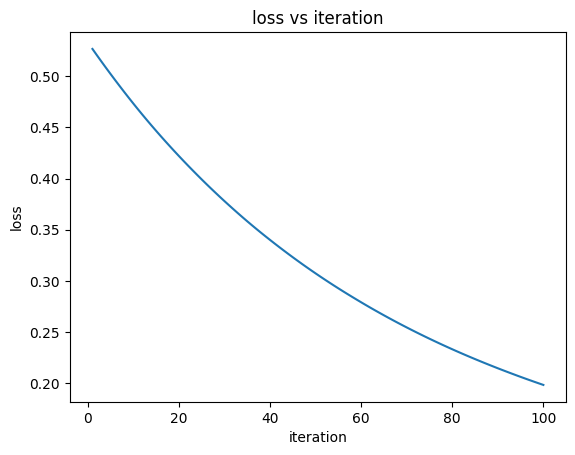

In [ ]:
# Plot the training loss
plt.plot(range(1, len(err) + 1), err)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss vs iteration')
plt.show()

In [ ]:
# Print errors
print(f'Training error is: {err[-1]}')
print(f'Validation error is: {calculate_error(X_value, y_value, number_of_layer, f_list, list_w, list_b)}')
print(f'Testing error is: {calculate_error(X_test, y_test, number_of_layer, f_list, list_w, list_b)}\n')

# Predictions and accuracies
y_train_pred = prediction(y_train, X_train, number_of_layer, f_list, list_w, list_b)
labeled_y_train = find_label(y_train_pred)
train_accuracy = accu(y_train, labeled_y_train)
print(f'Training accuracy is: {train_accuracy}')

y_value_pred = prediction(y_value, X_value, number_of_layer, f_list, list_w, list_b)
labeled_y_value = find_label(y_value_pred)
valueidation_accuracy = accu(y_value, labeled_y_value)
print(f'Validation accuracy is: {valueidation_accuracy}')

y_test_pred = prediction(y_test, X_test, number_of_layer, f_list, list_w, list_b)
labeled_y_test = find_label(y_test_pred)
test_accuracy = accu(y_test, labeled_y_test)
print(f'Testing accuracy is: {test_accuracy}')

Training error is: 0.19853921818248121
Validation error is: 0.1856692719412062
Testing error is: 0.16965775934535948

Training accuracy is: 0.4828571428571429
Validation accuracy is: 0.48
Testing accuracy is: 0.6


In [ ]:
# Evaluation metrics
print('Evaluation metric for train set:\n')
Evaluation_Matrix(y_train, labeled_y_train)

print('Evaluation metric for validation set:\n')
Evaluation_Matrix(y_value, labeled_y_value)

print('Evaluation metric for test set:\n')
Evaluation_Matrix(y_test, labeled_y_test)

Evaluation metric for train set:

True positive: 0, True negative: 169, False positive: 0, False negative: 181
The precision is: 0.0
The recall is: 0.0
The f1 score is: 0.0
The accuracy is: 0.4828571428571429 

Evaluation metric for validation set:

True positive: 0, True negative: 36, False positive: 0, False negative: 39
The precision is: 0.0
The recall is: 0.0
The f1 score is: 0.0
The accuracy is: 0.48 

Evaluation metric for test set:

True positive: 0, True negative: 45, False positive: 0, False negative: 30
The precision is: 0.0
The recall is: 0.0
The f1 score is: 0.0
The accuracy is: 0.6 



##With 3 Hidden Layers , Activation Functions in Hidden layers are ReLU and Sigmoid in OutPut layer

In [ ]:
# Initialize parameters
number_of_layer = 3
layer_sizes = [5, 3, 1]
weights_list, biases_list = parameter_initialization(X_train[0], layer_sizes)
f_list = [Relu, Relu, Sigmoid]

# Perform gradient descent
err, list_w, list_b = Gradient_descent(X_train, y_train, number_of_layer, f_list, weights_list, biases_list, learning_rate=0.01, nEpoch=500)

Error in 0th iteration = 0.818714980359718
Error in 1th iteration = 0.8152681556085559
Error in 2th iteration = 0.8118992211840079
Error in 3th iteration = 0.8086089827388573
Error in 4th iteration = 0.8053754597377536
Error in 5th iteration = 0.8021684292392828
Error in 6th iteration = 0.798987425414182
Error in 7th iteration = 0.7958412122869345
Error in 8th iteration = 0.7927719897365283
Error in 9th iteration = 0.7897432793570907
Error in 10th iteration = 0.7867692710702897
Error in 11th iteration = 0.7838484639506392
Error in 12th iteration = 0.7810403695378321
Error in 13th iteration = 0.7783420586681593
Error in 14th iteration = 0.775668646036952
Error in 15th iteration = 0.7730314453179731
Error in 16th iteration = 0.7704110896415316
Error in 17th iteration = 0.7678073496256356
Error in 18th iteration = 0.765220993938746
Error in 19th iteration = 0.7626954507947551
Error in 20th iteration = 0.7602180559178208
Error in 21th iteration = 0.7577846055412286
Error in 22th iteration 

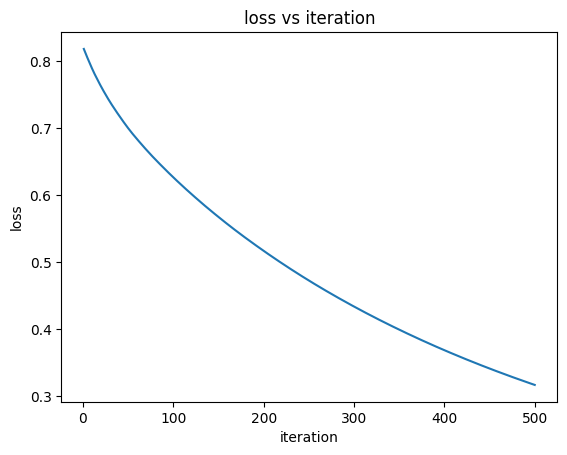

In [ ]:
# Plot the training loss
plt.plot(range(1, len(err) + 1), err)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss vs iteration')
plt.show()

In [ ]:
# Print errors
print(f'Training error is: {err[-1]}')
print(f'Validation error is: {calculate_error(X_value, y_value, number_of_layer, f_list, list_w, list_b)}')
print(f'Testing error is: {calculate_error(X_test, y_test, number_of_layer, f_list, list_w, list_b)}\n')

# Predictions and accuracies
y_train_pred = prediction(y_train, X_train, number_of_layer, f_list, list_w, list_b)
labeled_y_train = find_label(y_train_pred)
train_accuracy = accu(y_train, labeled_y_train)
print(f'Training accuracy is: {train_accuracy}')

y_value_pred = prediction(y_value, X_value, number_of_layer, f_list, list_w, list_b)
labeled_y_value = find_label(y_value_pred)
valueidation_accuracy = accu(y_value, labeled_y_value)
print(f'Validation accuracy is: {valueidation_accuracy}')

y_test_pred = prediction(y_test, X_test, number_of_layer, f_list, list_w, list_b)
labeled_y_test = find_label(y_test_pred)
test_accuracy = accu(y_test, labeled_y_test)
print(f'Testing accuracy is: {test_accuracy}')

Training error is: 0.3163516008811968
Validation error is: 0.3108403135487218
Testing error is: 0.25745230456304946

Training accuracy is: 0.4828571428571429
Validation accuracy is: 0.48
Testing accuracy is: 0.6


In [ ]:
# Evaluation metrics
print('Evaluation metric for train set:\n')
Evaluation_Matrix(y_train, labeled_y_train)

print('Evaluation metric for validation set:\n')
Evaluation_Matrix(y_value, labeled_y_value)

print('Evaluation metric for test set:\n')
Evaluation_Matrix(y_test, labeled_y_test)

Evaluation metric for train set:

True positive: 0, True negative: 169, False positive: 0, False negative: 181
The precision is: 0.0
The recall is: 0.0
The f1 score is: 0.0
The accuracy is: 0.4828571428571429 

Evaluation metric for validation set:

True positive: 0, True negative: 36, False positive: 0, False negative: 39
The precision is: 0.0
The recall is: 0.0
The f1 score is: 0.0
The accuracy is: 0.48 

Evaluation metric for test set:

True positive: 0, True negative: 45, False positive: 0, False negative: 30
The precision is: 0.0
The recall is: 0.0
The f1 score is: 0.0
The accuracy is: 0.6 

